# Evaluating exceedance probabilities from simple NAME runs

In this notebook I'll demonstrate how to use the code in order to set up and run a NAME ensemble and compute exceedance probabilities and their variances. 

First, run `pip install -e .` in order to install the python package.

In [2]:
import os
import sys
import iris

sys.path.append("../pvauncertainty/")
from csv_funs import *
from cubes import *
from plotting import *
from utils import *
from ph_sampling import *

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

%matplotlib inline

## Single plume height observation

### Setting up NAME runs

In this example, we consider an eruption from Grimsvotn that is 12km a.s.l. The vent is 1.725 km a.s.l. To assign a posterior distribution to the log-MER, we fit a Bayesian model for the power-law relationship and obtain a t-distribution. `set_ivespa_obs` provides a wrapper for doing this. The t-distribution is expressed as $t_\nu (\tilde\mu(h), \tilde\sigma^2(h))$, where $\tilde\mu(h)$ is a location parameter, $\tilde\sigma^2(h)$ a scale parameter (both dependent on the plume height), and $\nu$ the degrees of freedom.

In [3]:
height = 12000
volcano_height = 1725

ivespa = set_ivespa_obs(height, volcano_height)
print(f"Degrees of freedom: {ivespa.df}")
print(f"Location parameter: {ivespa.mu[0]}")
print(f"Scale parameter: {ivespa.Sigma[0]}")

Degrees of freedom: 128
Location parameter: 6.408837100525442
Scale parameter: 0.7714975020357396


`posterior_to_csv` evaluates the eruption source parameters for a (set of) plume height(s), to be put in the NAME input file. 

In [4]:
examples_dir = os.getcwd()
csv_file = "ex1.csv"
csv_path = examples_dir + csv_file

posterior_to_csv(ivespa, height, csv_file, volcano_height, labels = ["ex1"])

[{'label': 'ex1',
  'H (km asl)': 12.0,
  'mu': 6.408837100525442,
  'sigma': 0.7714975020357396,
  'df': 128,
  'Q (g s)': 2563522304.8315587,
  'Q (g hr)': 9228680297393.611,
  'Z (m)': 6862.5,
  'dZ (m)': 10275}]

The MER, `Q (g s)`, is exactly $10^{\tilde\mu(h)}$ g/s, where $\tilde\mu(h)$ is the mean (and median) value of the t-distribution.

`run_name_from_csv` will fill out given NAME input file(s) with the source parameters and submit to a SLURM queue. NAME requires a set of input files; examples of how certain blocks must be set up for compatibility with this function are given in `../scripts/`. Note `csv_path` must be the full path of the csv file.

**You will need to provide NAME input file(s) for the rest of the code to work.**

In [5]:
this_dir = os.getcwd()
input_dir = this_dir + "../scripts/"
output_dir = this_dir +  "../data/"
csv_path = this_dir + "/" + csv_file

run_in_name = False

if run_in_name: 
    run_name_from_csv(csv_path, 
                      "ex1", 
                      input_dir = input_dir,
                      output_dir = output_dir,
                      ensemble = True,
                      scr_file = "merph_ensemble_from_csv.scr")

### Exceedance probability evaluation and plotting

The NAME outputs are saved in the subdirectory `sample_0`. The function `get_prob_cube` evaluates exceedance probabilities for the VAAC thresholds, given the degrees of freedom and scale parameters of the t-distribution for the log-MER given height. 

Because NAME scales linearly with height, the log-ash concentration at each point $x \in \mathcal{X}$ given plume height $H=h$ and met data $M=m$ also follows a t-distribution 

$$ \log_{10} C(x) \vert \{ H=h, M=m\} \sim t_\nu \left( \log_{10} \text{NAME}(x; h, m) + \tilde\mu(h), \tilde\sigma^2 (h) \right), $$

where $C(x)$ is a random variable representing the ash-concentration at $x$, and $\text{NAME}(x; h,m)$ is the NAME output at $x$ given a uniform release of volcanic ash between the vent and $h$ given met data $m$ and a unit MER (1 kg/s). Because we have run NAME with MER $Q=10^{\tilde\mu(h)}$, the log-concentration at each point $x$ is exactly 

$$ \log_{10} C(x) \vert \{ H=h, M=m\} = \text{NAME}(x; h, m) + \tilde\mu(h).$$

If the threshold is $v$, then for each met member $m$ and point $x$, the exceedance probability is evaluated from the c.d.f. of the t-distribution

$$ \mathbb{P} (C(x) \geq v \vert H=h, M=m) = \mathbb{P} (\log_{10} C(x) \geq \log_{10} v \vert H=h, M=m) = 1 - F(log_{10} v \vert m, h),$$

where

$$F(log_{10} v \vert m, h) = \mathbb{P}(\log_{10} C(x) \leq z \vert H=h, M=m).$$

The exceedance probability given $h$ which takes into account the ensemble is then the average of the 18 conditional exceedance probabilities:

$$\mathbb{P}(C(x) \geq v \vert H=h) = \frac{1}{18} \sum_{i=1}^{18} \mathbb{P} (C(x) \geq v \vert H=h, M=m_k). $$

Specifying `z_level` and `time_inds` (both as lists) will evaluate exceedance only for those FLs and times.

In [7]:
load_cube = True
cube_file = output_dir + "control_prob_cube.nc"
ex1_dir = output_dir + "ex1/"

if not load_cube:
    ex1_prob_cube = get_prob_cube(ex1_dir, 
                                  df = ivespa.df,
                                  sigma = ivespa.Sigma[0], 
                                  h_km = height / 1000, 
                                  z_level = [25],
                                  time_inds = [6])
    iris.save(ex1_prob_cube, cube_file)
else:
    ex1_prob_cube = iris.load(cube_file)[0]

ex1_prob_cube


OSError: One or more of the files specified did not exist:
    * "/home/hg20831/Insync/hg20831@bristol.ac.uk/OneDrive Biz/Thesis/Met Office Proj/merphuncertainty/data/control_prob_cube.nc" didn't match any files

Use `plot_excprobs` to plot the exceedance probability contours.

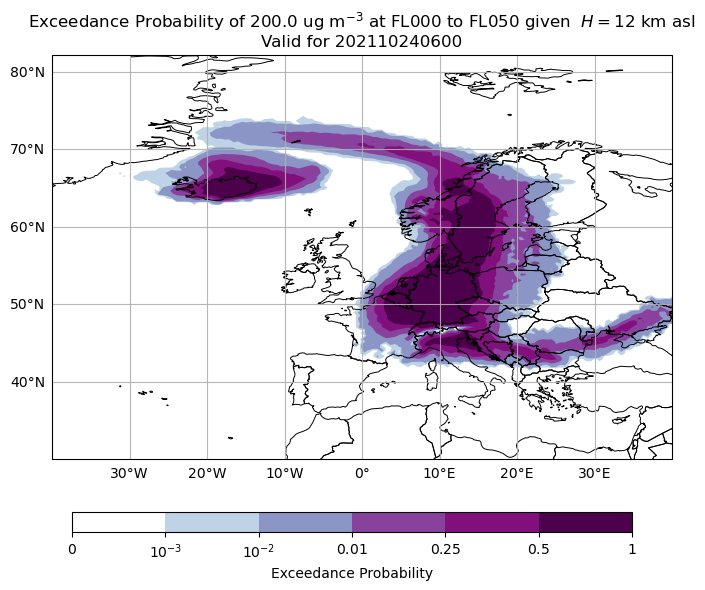

In [15]:
plot_excprobs(ex1_prob_cube, threshold = 0.0002, h_km = 12, 
              fl_index = 0, time_index = 0)

Use `plot_mult_excprobs` to plot these exceedance probabilities for each threshold, flight level, and time, or a subset for these, and save them to a subdirectory `excprobs` of the specified `workdir`.

In [16]:
plot = False
if plot:
    plot_mult_excprobs(ex1_prob_cube, workdir = examples_dir, h_km = 12, 
                       z_level = None, time_inds = [0], thresholds = None)

Use `plot_mult_excprobs` to plot the exceedance probabilities for a threshold, time and FL combination for each ensemble member on a grid. Currently this function evaluates the probabilities for each member.

Member 0 done.
Member 1 done.
Member 2 done.
Member 3 done.
Member 4 done.
Member 5 done.
Member 6 done.
Member 7 done.
Member 8 done.
Member 9 done.
Member 10 done.
Member 11 done.
Member 12 done.
Member 13 done.
Member 14 done.
Member 15 done.
Member 16 done.
Member 17 done.


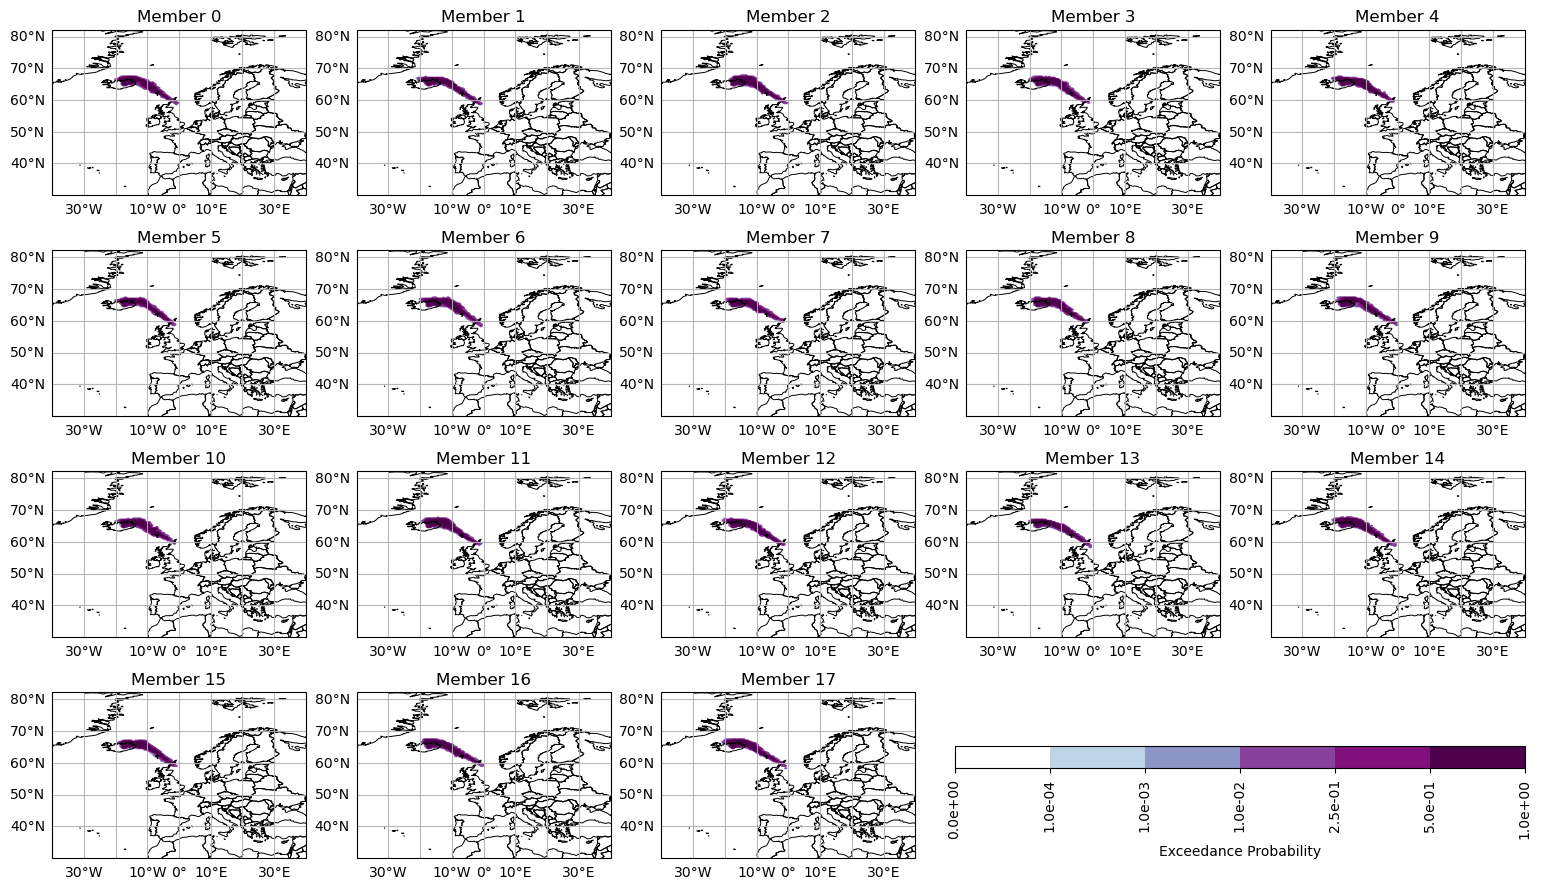

In [17]:
plot = False
if plot:
    plot_member_probs(ex1_dir, fl_index = 0, time_index = 0, threshold = 0.0002,
                      df = ivespa.df, sigma = ivespa.Sigma[0], h_km = 12)

## Percentiles evaluation and plotting

For $q \in [0,1]$ the $100q$-percentile is the value below which $100q%$ of observations will fall, or analogously the value above which $100(1-q)%$ of observations will fall. For a random variable $X$, this is the smallest value of $x$ such that 

$$F(x) = \mathbb{P}(X \geq x) \geq q.$$

This is obtained by an inversion of the c.d.f.: $x = F^{-1}(q)$. 

Since the distribution of the log-ash concentration conditional on height is a mixture of $K$ equally-weighted $t$-dists, its c.d.f. is the averge of $K$ component c.d.f.s whose inverse cannot be easily computed analytically. We can use a root-finding procedure however, and the implementation here is slow but can still be done.

In [21]:
load_ppf_cube = True
ppf_cube_file = examples_dir + "ex1_ppf.nc"

if not load_ppf_cube:
    _, ex1_ppf_cube = get_prob_cube(ex1_dir, 
                                    df = ivespa.df,
                                    sigma = ivespa.Sigma[0], 
                                    h_km = height / 1000,
                                    percentiles = True, 
                                    z_level = [25],
                                    time_inds = [6])
    iris.save(ex1_ppf_cube, ppf_cube_file)
else:
    ex1_ppf_cube = iris.load(ppf_cube_file)[0]

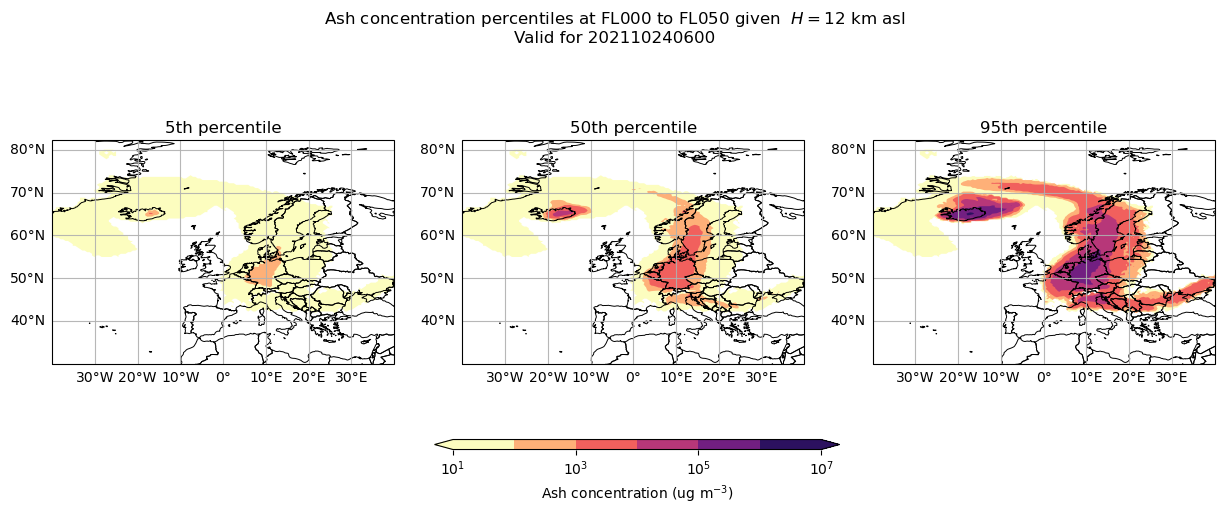

In [22]:
plot_ppfs(ex1_ppf_cube, h_km = 12, time_index=0, fl_index=0)

## Multiple plume height samples

Suppose there is uncertainty in the plume height observation, so we want to evaluate exceedance probabilities for a range of heights. The simplest and most straightforward (but definitely not the fastest) way of doing this is to run NAME for each ensemble member, for each of these heights.

In this example, we have a plume height observation of 12km +/- 1km, so we "sample" (not really) 5 plume heights between 10 and 14km.

In [6]:
heights = [10000, 11000, 12000, 13000, 14000]
volcano_height = 1725

ivespa = set_ivespa_obs(heights, volcano_height)
print(f"Degrees of freedom: {ivespa.df}")
print(f"Location parameters: {ivespa.mu}")
print(f"Scale parameters: {ivespa.Sigma}")

csv_file = "ex2.csv"
csv_path = examples_dir + "/" + csv_file

posterior_to_csv(ivespa, heights, csv_file, volcano_height)

run_in_name = False

if run_in_name: 
    run_name_from_csv(csv_path, 
                      "ex2", 
                      input_dir = input_dir,
                      output_dir = output_dir,
                      ensemble = True, 
                      scr_file = "chunk_ensemble_from_csv.scr")

Degrees of freedom: 128
Location parameters: [6.07586907 6.25134545 6.4088371  6.55169026 6.68239623]
Scale parameters: [0.77090038 0.77114368 0.7714975  0.77192912 0.77241612]


The exceedance probability taking into account this uncertainty in the plume height is the average of exceedance probabilities conditional on height.

$$\hat{p}_N(x; v) := \mathbb{P}(C(x) \geq v) = \frac{1}{N} \sum_{n=1}^{N} p^{(n)}(x; v), $$

where we have computed

$$p^{(n)}(x; v) := \mathbb{P}(C(x) \geq v \vert H=h^{(n)}) = \sum_{k=1}^{18} \mathbb{P}(C(x) \geq v \vert H = h^{(n)}, M = m_k), $$

for each plume height sample $h^{(n)}$, $n=1, \dots, N$. `avg_prob_cubes` computes these probability estimates given a directory containing subdirectories corresponding to the ensemble NAME outputs of each sample. It also computes the sample variance of the estimates, which is given by

$$s_N^2 (x;v) := \frac{1}{N-1} \left(p^{(n)}(x;v) - \hat{p}_N (x;v)\right)^2.$$


In [ ]:
load_cube = True
prob_file = examples_dir + "ex2_probs.nc"
svar_file = examples_dir + "ex2_svar.nc"
ex2_dir = output_dir + "/ex2/"

if not load_cube:
    ex2_prob_cube, ex2_svar_cube = avg_prob_cubes(
        ex2_dir, 
        csv_file,
        sample_var = True,
        percentiles = False,
        time_inds = [6],
        z_level = [25])
    iris.save(ex2_prob_cube, prob_file)
    iris.save(ex2_svar_cube, svar_file)
else:
    ex2_prob_cube = iris.load(prob_file)[0]
    ex2_svar_cube = iris.load(svar_file)[0]


Plotting the exceedance probability contours is again straightforward.

In [ ]:
plot_excprobs(ex2_prob_cube, threshold = 0.0002, h_km = "12 \pm 2", 
              fl_index = 0, time_index = 0)

For $\alpha \in (0,1)$, a $100(1-\alpha)$% confidence interval for a parameter $p$ (in our case the exceedance probability) such that the true value of $p$ lies within it with probability at least $1-\alpha$. 

Given $N$ samples, we approximate a CI for the exceedance probability $p(x;v) = \mathbb{P}(C(x) \geq v)$ by its estimate $p_N(x;v)$ and estimated variance $s_N^2(x;v)$:

$$ \hat{p}_N (x; v) \pm \sqrt{\frac{s_N^2(x;v)}{N}}.$$

`get_ci_cube` computes the 95% CI (\alpha=0.05) by default, but this can be changed by specifying `alpha` in the function call.

In [ ]:
ci_cube = get_ci_cube(ex2_prob_cube, ex2_svar_cube, n_samples = len(heights))

In [ ]:
plot_cis(ci_cube, threshold=0.0002, h_km = "12 \pm 2", 
         fl_index = 0, time_index = 0, log = False, vmin = 0, vmax = 1,
         cmap = "BuPu")

It is difficult to see the differences on this scale, especially for smaller probabilities, so we may wish to consider a CI for the log-probability instead. Taking the logarithm of the endpoints of the CI would not result in a CI that is symmetric about the log-probability estimate. Instead we can use

$$\log \hat{p}_N(x;v) \pm \frac{1}{\hat{p}_N(x;v)}\sqrt{\frac{s_N^2(x;v)}{N}}.$$

Setting `log=True` in `get_ci_cube` will compute this CI.

In [ ]:
log_ci_cube = get_ci_cube(ex2_prob_cube, ex2_svar_cube, len(heights), log = True)

In [ ]:
plot_cis(log_ci_cube, threshold=0.01, h_km = "12 \pm 2", 
         fl_index = 0, time_index = 0, log = True, vmin = -3, vmax = 0,
         cmap = "BuPu", extend = "min")